In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import glob

from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import threshold_li, threshold_otsu
from scipy.stats import ttest_ind

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
font_files = font_manager.findSystemFonts(fontpaths='/cluster2/home/futing/miniforge3/envs/juicer/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)

%cd /cluster2/home/futing/Project/panCancer/Analysis/conserve

/cluster2/home/futing/Project/panCancer/Analysis/conserve


# 完全匹配 BS

In [2]:
bin=pd.read_csv(f'/cluster2/home/futing/Project/panCancer/Analysis/conserve/BS537_col8_0104.tsv', sep="\t")


In [3]:
resinfo=pd.read_csv('/cluster2/home/futing/Project/panCancer/check/meta/PanmergedMeta_0104.txt',sep='\t')
resinfo.shape

(538, 12)

### cancer 的 BS

In [ ]:
bin1=bin.drop(columns=resinfo.loc[resinfo['isctrl']==1,'ncell'].tolist()) # 删除 normal 细胞系
bin1.shape,bin.shape #((61776, 442), (61776, 540))

((61776, 442), (61776, 540))

In [5]:
resinfo.head()

,cancer,gse,cell,clcell,isctrl,istreated,ncell,isCapture,depth,reso,Cancer_Category,Origin
0,AA,GSE81879,AA86,AA86,0,0,AA86,0,6968351,203800,Solid Tumor,Central Nervous System
1,ALL,GSE145997,ALL_PDX17,ALL_PDX17,0,0,ALL_PDX17,0,63639853,9400,Hematological (Leukemia),Hematological
2,ALL,GSE145997,ALL_PDX19,ALL_PDX19,0,0,ALL_PDX19,0,47101158,9300,Hematological (Leukemia),Hematological
3,ALL,GSE145997,ALL_PDX23,ALL_PDX23,0,0,ALL_PDX23,0,94214218,4300,Hematological (Leukemia),Hematological
4,ALL,GSE145997,ALL_PDX29,ALL_PDX29,0,0,ALL_PDX29,0,79135914,5450,Hematological (Leukemia),Hematological


In [ ]:
blacklist = resinfo.nsmallest(10, 'depth')['ncell']  # 'depth' 最少的也是他们

# 获取要排除的列名列表
exclude_cols = set(resinfo.loc[resinfo['isCapture']==1, 'ncell']).union(set(blacklist))

bin_filbyQC = bin1.loc[:, ~bin1.columns.isin(exclude_cols)]
print(f'After QC: {bin_filbyQC.shape}; Before QC: {bin1.shape}')
# After QC: (61776, 425); Before QC: (61776, 442)

After QC: (61776, 425); Before QC: (61776, 442)


In [7]:
# 看看排除的 cell type 是不是对的上
len(exclude_cols) 
#17 3 =20
#422 95 = 517
len(exclude_cols.intersection(set(bin.columns)))
# 20

20

In [8]:
# 检查一下 MYC 的问题，一共 185 个细胞系存在
cells=bin_filbyQC.loc[
    (bin_filbyQC['chrom']=='chr8') & 
    (bin_filbyQC['start']>=127700000) & 
    (bin_filbyQC['end']<=127750000)
].dropna(axis=1).columns.tolist()[3:]  # 选取部分 boundary 查看
len(cells)

185

In [14]:
# 查看含有 MYC boundary的细胞系比例
MYC_pro=resinfo.loc[resinfo['ncell'].isin(cells),'cancer'].value_counts()/resinfo['cancer'].value_counts()
MYC_pro=MYC_pro.sort_values(ascending=False)
MYC_pro.head()

cancer
AA      1.000000
TALL    0.687500
NB      0.636364
GBM     0.619048
AML     0.588235
Name: count, dtype: float64

In [16]:
threshold=0.4
threshold*(bin_filbyQC.shape[1]-3) #213

168.8

In [ ]:
# 筛选 NA
threshold=0.4
# fil = bin_filbyQC.notna().sum(axis=1) <= threshold*(bin.shape[1]) # 147.5 个细胞中存在视为保守。原本的，比较宽松，
fil = bin_filbyQC.notna().sum(axis=1) >= threshold*(bin_filbyQC.shape[1]-3) # 168.8 个细胞中存在视为保守
bin_fil = bin_filbyQC.loc[fil,:] #(3061, 358) #(2255, 358) #(2345, 427) #(3477, 425)
bin_any = bin_filbyQC.loc[bin_filbyQC.notna().any(axis=1),:] # 所有的boundary (61776, 427) #(61776, 425)
print(f"Original bin shape: {bin_filbyQC.shape}, After filtering NA > {threshold*100}% bin shape: {bin_fil.shape}, All boundary bin shape: {bin_any.shape}")

Original bin shape: (61776, 425), After filtering NA > 40.0% bin shape: (3477, 425), All boundary bin shape: (61776, 425)


In [ ]:
bin_fil.to_csv('./midata/0108/bin/panCan_0108_50k800k.bed', sep="\t", index=False)
# bin_fil = pd.read_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/panCan327_50k800k.bed', sep="\t", header=0)
# bin_fil.head()

In [19]:
# 计算每个细胞系有多少 conserve boundary
nCB = bin_fil.iloc[:,3:].notna().sum(axis=0) # 每列非NA的行数
# 注释一下
nCB_df=pd.merge(nCB.to_frame(name='nConBoun'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nCB_df= nCB_df.sort_values(by='nConBoun', ascending=False) # 按照 non_na_ratio 排序
# nCB_ratio.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_50k800k.tsv', sep="\t", header=True)

In [20]:
# 计算每个细胞系有多少 boundary
nB = bin_filbyQC.iloc[:,3:].notna().sum(axis=0)

nB_df=pd.merge(nB.to_frame(name='nBoun'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nB_df= nB_df.sort_values(by='nBoun', ascending=True) # 按照 non_na_ratio 排序
# df.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [21]:
# 每个细胞系 conserve boundary 的数量/每个细胞系 boundary 的数量 = conserve boundary ratio
nCBmB_ratio = bin_fil.iloc[:,3:].notna().sum(axis=0) / bin_filbyQC.iloc[:,3:].notna().sum(axis=0)
nCBmB_df=pd.merge(nCBmB_ratio.to_frame(name='ConBoun_ratio'), resinfo, left_index=True, right_on='ncell',how='inner') # 合并 cancer 和 ncell 
nCBmB_df= nCBmB_df.sort_values(by='ConBoun_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('./midata/412/nCBmB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [22]:
# 合并所有的统计数据
CB_data = pd.DataFrame({
	'nCB': nCB,
	'nB': nB,
	'nCBmB_ratio': nCBmB_ratio,

})
CB_data = CB_data.reset_index().rename(columns={'index': 'ncell'})
CB_data = CB_data.merge(resinfo, on='ncell', how='inner')
CB_data = CB_data.sort_values(by='nCBmB_ratio', ascending=True)
# CB_data=CB_data.dropna()

In [23]:
CB_data.shape,bin_filbyQC.shape,len(nCB)

((422, 15), (61776, 425), 422)

In [ ]:
CB_data.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/midata/0108/bin/CB_data_010850k800k.tsv', sep="\t", header=True, index=False)
# CB_data=pd.read_csv('./midata/412/CB_data_50k800k.tsv',sep="\t")

In [68]:
CB_data.head()

,ncell,nCB,nB,nCBmB_ratio,cancer,gse,cell,clcell,isctrl,istreated,isCapture,depth,reso,Cancer_Category,Origin
119,HELA_22,681,11475,0.059346,CESC,GSE152373,HeLa_Prometa,HELA,0,0,0,36857780,23700,Solid Tumor,Reproductive System
102,HELA_5,618,9678,0.063856,CESC,GSE102884,HeLa_Prometa,HELA,0,0,0,21336066,18850,Solid Tumor,Reproductive System
85,MCF7_9,713,9745,0.073166,BRCA,GSE195810,MCF7M1,MCF7,0,0,0,692282,235950,Solid Tumor,Reproductive System
11,HL60_2,786,9615,0.081747,AML,GSE120815,HL-60_S4,HL60,0,0,0,14969491,109200,Hematological (Leukemia),Hematological
112,HELA_14,852,10252,0.083106,CESC,GSE119825,HeLa_clone27k_mitotic,HELA,0,0,0,18952620,53750,Solid Tumor,Reproductive System


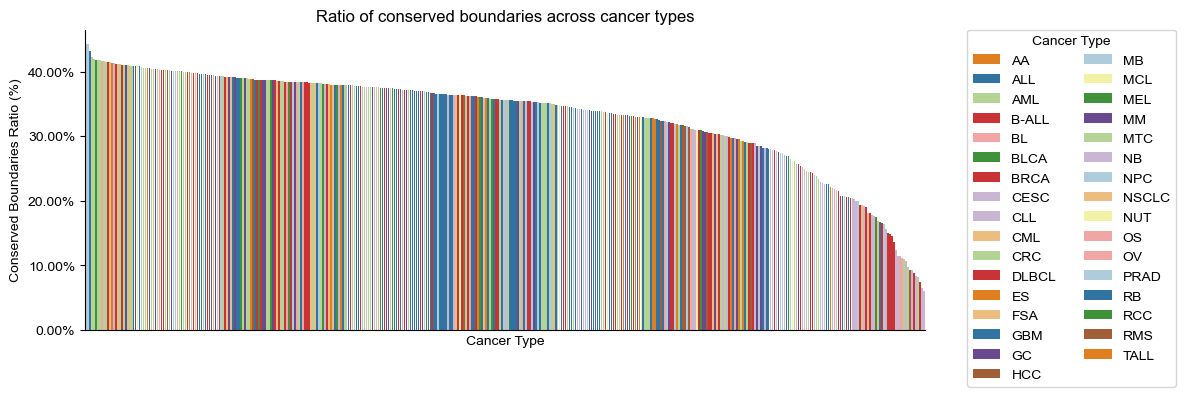

In [74]:
fig, ax = plt.subplots(figsize=(12, 4)) 
df=nCBmB_df # 由于上面的问题删除 NA
# 使用 Paired 调色板，为每种癌症类型分配不同颜色
unique_cancers = df['cancer'].nunique()
set1 = sns.color_palette("Paired", unique_cancers)

# 创建条形图，按癌症类型上色
ax = sns.barplot(x=df.ncell, y=df['ConBoun_ratio'], 
                 hue=df['cancer'],  # 按癌症类型分组上色
                 palette=set1,      # 使用Paired调色板
                 dodge=False)       # 确保不分开显示
# ax = sns.violinplot(x=df['cancer'],y=df['ConBoun_ratio'],palette=set1,hue=df['cancer'])

plt.title("Ratio of conserved boundaries across cancer types")
# plt.title("Number of boundaries across cancer types")
plt.xticks([])
plt.xlabel("Cancer Type")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# plt.ylabel("Num of Boundaries")

# 将纵轴改为百分制
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# 添加图例
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

plt.tight_layout()
# plt.savefig('/cluster2/home/futing/Project/panCancer/Analysis/conserve/plot/0104/nCBmB_ratio_50k800k.pdf', dpi=500)

In [86]:
order = df.groupby('cancer')['ConBoun_ratio'].mean().sort_values(ascending=False).index.tolist()

/tmp/ipykernel_2733/2841503847.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


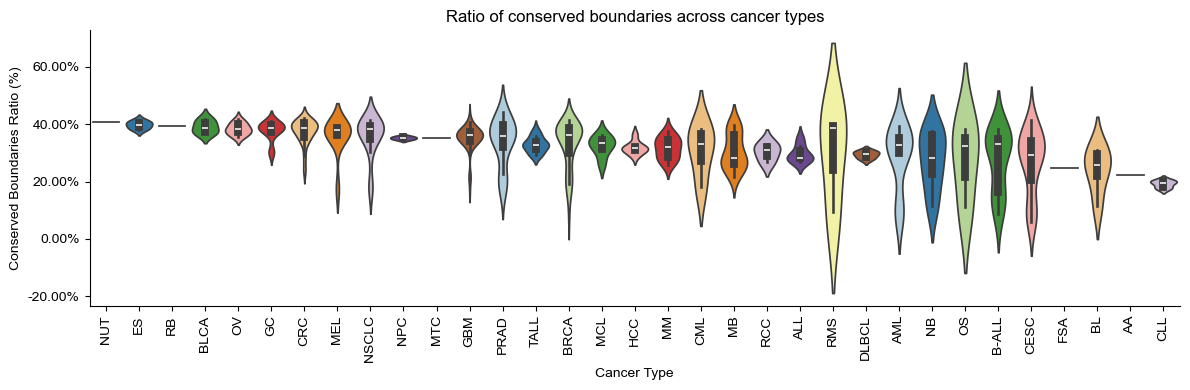

In [87]:
fig, ax = plt.subplots(figsize=(12, 4)) 
df = nCBmB_df

# 使用 Paired 调色板
unique_cancers = df['cancer'].nunique()
set1 = sns.color_palette("Paired", unique_cancers)

# 创建 violin 图，按癌症类型上色
ax = sns.violinplot(
    data=df,
    x='cancer',              # x 轴是癌症类型
    y='ConBoun_ratio',       # y 轴是比例
    palette=set1,            # 颜色
    order=order  # 可选：按字母排序
)

plt.title("Ratio of conserved boundaries across cancer types")
plt.xticks(rotation=90)  # 旋转 x 轴标签
plt.xlabel("Cancer Type")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# 将纵轴改为百分制
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

plt.tight_layout()
plt.savefig('/cluster2/home/futing/Project/panCancer/Analysis/conserve/plot/0104/nCBmB_ratio_50k800k.pdf', dpi=500)

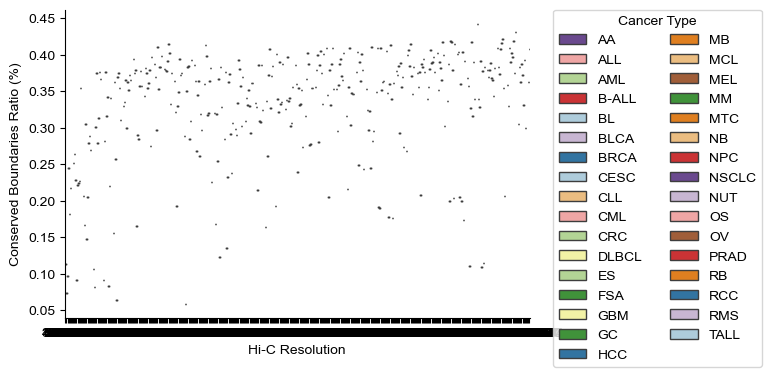

In [ ]:
# res 与 conserve boundary ratio 关系
fig, ax = plt.subplots(figsize=(6, 4)) 
df=nCBmB_df # 由于上面的问题删除 NA
sns.boxplot(data=df, x=df['depth'].astype(int), y='ConBoun_ratio', palette=set1,hue='cancer')
plt.xlabel("Hi-C Resolution")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# 添加图例
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

### Ctrl 的 BS

In [25]:
bin2=bin.drop(columns=resinfo.loc[resinfo['isctrl']==0,'ncell'].tolist(),errors='ignore') # 删除 normal 细胞系
bin2.shape,bin.shape #((61776, 101), (61776, 540))

((61776, 101), (61776, 540))

In [26]:
blacklist = resinfo.nsmallest(10, 'depth')['ncell']  # 'depth' 最少的也是他们

# 获取要排除的列名列表
exclude_cols = set(resinfo.loc[resinfo['isCapture']==1, 'ncell']).union(set(blacklist))

bin2_filbyQC = bin2.loc[:, ~bin2.columns.isin(exclude_cols)]
print(f'After QC: {bin2_filbyQC.shape}; Before QC: {bin2.shape}') 
#After QC: (61776, 98); Before QC: (61776, 101)

After QC: (61776, 98); Before QC: (61776, 101)


In [ ]:
# 筛选 NA
threshold=0.4
fil = bin2_filbyQC.notna().sum(axis=1) >= threshold*(bin2.shape[1]-3) # 98-3/2=47.5 个细胞中存在视为保守
binctrl_fil = bin2_filbyQC.loc[fil,:] #(3061, 358) #(2255, 358)
print(f"Original bin shape: {bin2.shape}, After filtering NA > {threshold*100}% bin shape: {binctrl_fil.shape}")
# Original bin shape: (61776, 101), After filtering NA > 50.0% bin shape: (2362, 98), All boundary bin shape: (61776, 101)
# Original bin shape: (61776, 101), After filtering NA > 40.0% bin shape: (3469, 98)

Original bin shape: (61776, 101), After filtering NA > 40.0% bin shape: (3469, 98)


In [ ]:
binctrl_fil.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/midata/0108/bin/Ctrl_010850k800k.bed',sep='\t',index=False)

In [28]:
# 计算每个细胞系有多少 conserve boundary
nCBctrl = binctrl_fil.iloc[:,3:].notna().sum(axis=0)
# 注释一下
nCBctrl_df=pd.merge(nCBctrl.to_frame(name='nCB'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nCBctrl_df= nCBctrl_df.sort_values(by='nCB', ascending=False) # 按照 non_na_ratio 排序

In [29]:
# 计算每个细胞系有多少 boundary
nBctrl = bin2_filbyQC.iloc[:,3:].notna().sum(axis=0)
nBctrl_df=pd.merge(nBctrl.to_frame(name='nB'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nBctrl_df= nBctrl_df.sort_values(by='nB', ascending=False) # 按照 nB 排序
# nCB_ratio.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_50k800k.tsv', sep="\t", header=True)

In [30]:
# 每个细胞系 conserve boundary 的数量/每个细胞系 boundary 的数量 = conserve boundary ratio
nCBmBctrl_ratio = binctrl_fil.iloc[:,3:].notna().sum(axis=0) / bin2_filbyQC.iloc[:,3:].notna().sum(axis=0)
nCBmBctrl_df=pd.merge(nCBmBctrl_ratio.to_frame(name='ConBoun_ratio'), resinfo, left_index=True, right_on='ncell',how='inner') # 合并 cancer 和 ncell 
nCBmBctrl_df= nCBmBctrl_df.sort_values(by='ConBoun_ratio', ascending=False) # 按照 non_na_ratio 排序

In [31]:
# 合并所有的统计数据
CBctrl_data = pd.DataFrame({
	'nCB': nCBctrl,
	'nB': nBctrl,
	'nCBmB_ratio': nCBmBctrl_ratio,

})
CBctrl_data = CBctrl_data.reset_index().rename(columns={'index': 'ncell'})
CBctrl_data = CBctrl_data.merge(resinfo, on='ncell', how='inner')
CBctrl_data = CBctrl_data.sort_values(by='nCBmB_ratio', ascending=True)
# CBctrl_data=CBctrl_data.dropna()

In [32]:
CBctrl_data.shape

(95, 15)

In [ ]:
CBctrl_data.to_csv("/cluster2/home/futing/Project/panCancer/Analysis/conserve/midata/0108/bin/CBctrl_data_010850k800k.tsv",sep='\t',index=False)

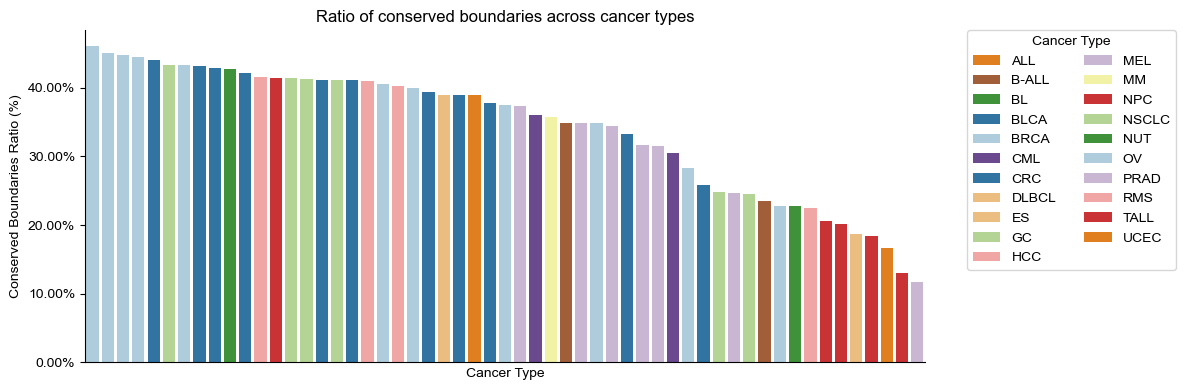

In [17]:
fig, ax = plt.subplots(figsize=(12, 4)) 
df=nCBmBctrl_df.dropna() # 由于上面的问题删除 NA
# 使用 Paired 调色板，为每种癌症类型分配不同颜色
unique_cancers = df['cancer'].nunique()
set1 = sns.color_palette("Paired", unique_cancers)

# 创建条形图，按癌症类型上色
ax = sns.barplot(x=df.ncell, y=df['non_na_ratio'], 
                 hue=df['cancer'],  # 按癌症类型分组上色
                 palette=set1,      # 使用Paired调色板
                 dodge=False)       # 确保不分开显示

plt.title("Ratio of conserved boundaries across cancer types")
# plt.title("Number of boundaries across cancer types")
plt.xticks([])
plt.xlabel("Cancer Type")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# plt.ylabel("Num of Boundaries")

# 将纵轴改为百分制
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# 添加图例
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('./plot/nCBmBctrl_ratio_50k800k.pdf', dpi=500)

In [66]:
rCB_Cvct=pd.concat([	pd.DataFrame({
		'rCB':nCBmB_ratio,
		'type':'CANCER'
	}),
	pd.DataFrame({
		'rCB':nCBmBctrl_ratio,
		'type':'CTRL'
	})],ignore_index=True

).dropna()
# rCB_Cvct['rCB']=rCB_Cvct['rCB']*100

In [59]:
def add_stat_annotation(ax, x1, x2, y, p_value, line_height=0.02):
    """添加统计标注的通用函数"""
    
    # 计算星号标记
    if p_value < 0.001:
        p_text = '***'
    elif p_value < 0.01:
        p_text = '**'
    elif p_value < 0.05:
        p_text = '*'
    else:
        p_text = f'p = {p_value:.3f}'
    
    # 绘制横杠
    h = y * line_height
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], 
            lw=1.5, color='black', marker='')
    
    # 添加文本
    ax.text((x1+x2)*0.5, y+h, p_text, 
            ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

/tmp/ipykernel_98693/2721569846.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',


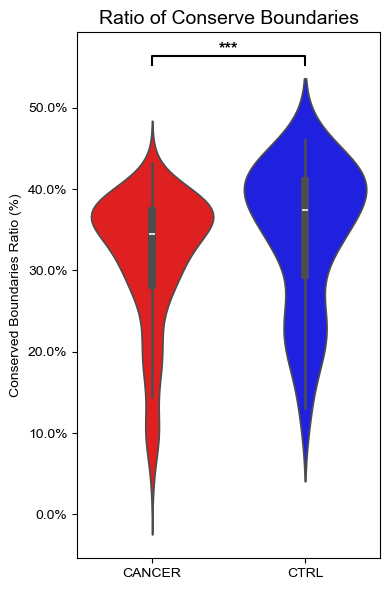

In [68]:
plt.figure(figsize=(4, 6))

ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',
                   palette=['red', 'blue'])

# 计算p值
_, p_value = stats.mannwhitneyu(cancer_data, ctrl_data)
cancer_data = rCB_Cvct[rCB_Cvct['type']=='CANCER']['rCB']
ctrl_data = rCB_Cvct[rCB_Cvct['type']=='CTRL']['rCB']
# 添加标注
y_max = rCB_Cvct['rCB'].max()
add_stat_annotation(ax, 0, 1, y_max*1.2, p_value)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.title('Ratio of Conserve Boundaries', fontsize=14)
plt.ylabel("Conserved Boundaries Ratio (%)")
plt.xlabel("")
plt.tight_layout()
plt.savefig('./plot/CanVSCtrl_nCBmB_50k800k.pdf', dpi=500)

/tmp/ipykernel_98693/1728107228.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',


CANCER vs. CTRL: Custom statistical test, P_val:2.051e-04


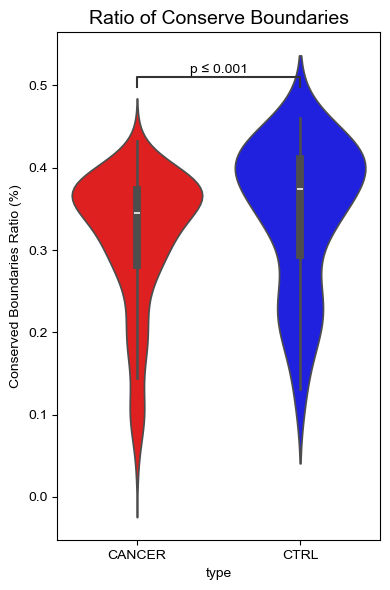

In [ ]:
from scipy import stats
from statannotations.Annotator import Annotator

plt.figure(figsize=(4, 6))
ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',
                   palette=['red', 'blue'])

# 进行t检验
cancer_data = rCB_Cvct[rCB_Cvct['type']=='CANCER']['rCB']
ctrl_data = rCB_Cvct[rCB_Cvct['type']=='CTRL']['rCB']
u_stat, p_value = stats.mannwhitneyu(cancer_data, ctrl_data, alternative='two-sided')
# t_stat, p_value = stats.ttest_ind(cancer_data, ctrl_data)
# print(f"曼-惠特尼U检验: U = {u_stat:.4f}, p = {p_value:.4f}")
pairs = [("CANCER", "CTRL")]
pvalues = [p_value]  # 使用你计算出的p值

# 添加统计标注
annotator = Annotator(ax, pairs, data=rCB_Cvct, x='type', y='rCB')
annotator.configure(text_format='simple', loc='inside')
annotator.set_pvalues(pvalues)
annotator.annotate()

# # 添加p值标注
# plt.text(0.5, plt.ylim()[1]*0.9, f'p-value = {p_value:.4f}', 
#          ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))
plt.title('Ratio of Conserve Boundaries', fontsize=14)
plt.ylabel("Conserved Boundaries Ratio (%)")
plt.tight_layout()
# plt.savefig('./plot/CanVSCtrl_nCBmB_50k800k.pdf', dpi=500)